# Analysis and visualisations of loan data

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [5]:
df = pd.read_csv('transformed_df.csv')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          54231 non-null  float64
 1   member_id                   54231 non-null  float64
 2   loan_amount                 54231 non-null  float64
 3   funded_amount               54231 non-null  float64
 4   funded_amount_inv           54231 non-null  float64
 5   term                        49459 non-null  object 
 6   int_rate                    54231 non-null  float64
 7   instalment                  54231 non-null  float64
 8   grade                       54231 non-null  object 
 9   sub_grade                   54231 non-null  object 
 10  employment_length           52113 non-null  object 
 11  home_ownership              54231 non-null  object 
 12  annual_inc                  54231 non-null  float64
 13  verification_status         542

#### Current state of the loans

In [7]:
# Current recovery percentage
current_recovery_percentage = (df['total_payment'].sum() / df['funded_amount'].sum()) * 100
print(current_recovery_percentage)

98.35445798117803


c:\Users\timur\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


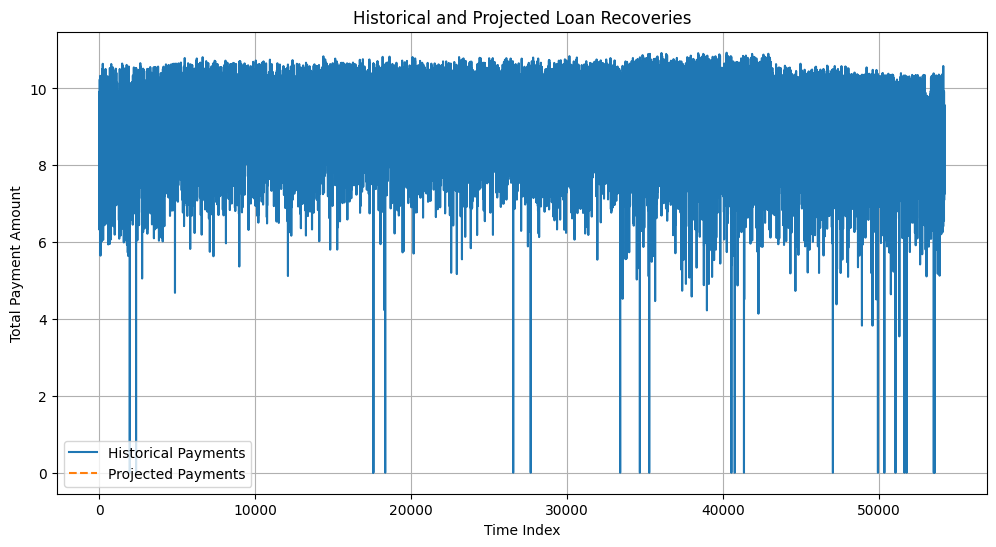

(9.150475479646019, 0.0018170380043558768)

In [9]:
# Create a time index (assuming the data is sorted by date)
df['time_index'] = range(len(df))

# Create a linear regression model
model = LinearRegression()

# Fit the model using time_index as the feature and total_payment as the target
model.fit(df[['time_index']], df['total_payment'])

# Forecast the next 6 months (assuming monthly data, add 6 to the time index)
future_time_index = df['time_index'].max() + np.array([1, 2, 3, 4, 5, 6])
future_payments = model.predict(future_time_index.reshape(-1, 1))

# Calculate the projected recovery amount in 6 months
projected_recovery_in_6_months = future_payments[-1]

# Calculate the projected recovery percentage
projected_recovery_percentage = (projected_recovery_in_6_months / df['funded_amount'].sum()) * 100

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(df['time_index'], df['total_payment'], label='Historical Payments')
plt.plot(future_time_index, future_payments, label='Projected Payments', linestyle='--')
plt.xlabel('Time Index')
plt.ylabel('Total Payment Amount')
plt.title('Historical and Projected Loan Recoveries')
plt.legend()
plt.grid(True)
plt.show()

projected_recovery_in_6_months, projected_recovery_percentage


### Calculating loss

In [10]:
# Filtering data for loans marked as 'Charged Off'
charged_off_loans = df[df['loan_status'] == 'Charged Off']

# Calculate the number of charged off loans
num_charged_off_loans = charged_off_loans.shape[0]

# Calculate the total number of loans
total_num_loans = df.shape[0]

# Calculate the percentage of loans that were charged off
percentage_charged_off = (num_charged_off_loans / total_num_loans) * 100

# Calculate the total amount paid towards these charged off loans
total_paid_charged_off_loans = charged_off_loans['total_payment'].sum()

percentage_charged_off, total_paid_charged_off_loans

(10.272722243735133, 46906.64092611155)

### Calculating projected loss

In [22]:
# Calculating total interest revenue from all loans
total_interest_revenue_all_loans = df['total_rec_int'].sum()

# Extracting numerical part from 'term' and converting to integer for charged off loans
charged_off_loans['term_months'] = charged_off_loans['term'].str.extract('(\d+)')
charged_off_loans['term_months'] = charged_off_loans['term_months'].fillna(0).astype(int)

# Calculating expected interest revenue for charged off loans
charged_off_loans['expected_interest_revenue'] = (charged_off_loans['loan_amount'] * 
                                                  (charged_off_loans['int_rate'] / 100) * 
                                                  (charged_off_loans['term_months'] / 12))

# Calculating total expected interest revenue and actual interest received from 'Charged Off' loans
total_expected_interest_revenue = charged_off_loans['expected_interest_revenue'].sum()
actual_interest_received = charged_off_loans['total_rec_int'].sum()

# Calculating projected loss of revenue and percentage revenue lost
projected_loss_of_revenue = total_expected_interest_revenue - actual_interest_received
percentage_revenue_lost = (projected_loss_of_revenue / total_interest_revenue_all_loans) * 100

total_expected_interest_revenue, projected_loss_of_revenue, percentage_revenue_lost


C:\Users\timur\AppData\Local\Temp\ipykernel_14472\3119279264.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charged_off_loans['term_months'] = charged_off_loans['term'].str.extract('(\d+)')
C:\Users\timur\AppData\Local\Temp\ipykernel_14472\3119279264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charged_off_loans['term_months'] = charged_off_loans['term_months'].fillna(0).astype(int)
C:\Users\timur\AppData\Local\Temp\ipykernel_14472\3119279264.py:11: SettingWithCopyWarning: 
A value is trying to 

(27927.18218209513, -11947.9523939879, -2.9810719301479724)

### Possible Loss

In [25]:
# Identifying loans where customers are behind on payments
behind_statuses = ['Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)']
loans_behind = df[df['loan_status'].isin(behind_statuses)]

# Calculate the number and percentage of these loans
num_loans_behind = loans_behind.shape[0]
total_num_loans = df.shape[0]
percentage_loans_behind = (num_loans_behind / total_num_loans) * 100

num_loans_behind, percentage_loans_behind


(951, 1.753609559108259)

In [26]:
# Potential loss if these loans change to 'Charged Off'
potential_loss_if_charged_off = loans_behind['out_prncp'].sum()
potential_loss_if_charged_off


8246.563105265623

In [27]:
# Checking for columns that might indicate the remaining term of the loans
potential_columns_for_remaining_term = [col for col in df.columns if 'term' in col]
potential_columns_for_remaining_term


['term']

In [29]:
# Extracting the numerical part from 'term' and converting to integer for loans behind
loans_behind['term_months'] = loans_behind['term'].str.extract('(\d+)').fillna(0).astype(int)

# Assuming the loans are halfway through their term
remaining_term_months = loans_behind['term_months'] / 2

# Calculating the monthly interest rate (annual rate divided by 12)
monthly_interest_rate = loans_behind['int_rate'] / 100 / 12

# Estimating the remaining interest for each loan
# Using a simplified formula: Interest = Principal * Rate * Time
estimated_remaining_interest = loans_behind['out_prncp'] * monthly_interest_rate * remaining_term_months

# Total projected loss if these loans were to finish their term (sum of remaining interest)
total_projected_loss = estimated_remaining_interest.sum()

# Summing the outstanding principal for 'Charged Off' loans
charged_off_loans = df[df['loan_status'] == 'Charged Off']
loss_from_charged_off_loans = charged_off_loans['out_prncp'].sum()

# Total loss from both 'behind' and 'Charged Off' loans (principal + projected interest for 'behind' loans)
total_combined_loss = loss_from_charged_off_loans + potential_loss_if_charged_off + total_projected_loss

# Sum of all received payments (principal + interest) from all loans
total_received_payments = df['total_payment'].sum()

# Percentage of total revenue affected
percentage_total_revenue_affected = (total_combined_loss / total_received_payments) * 100

total_combined_loss, percentage_total_revenue_affected

C:\Users\timur\AppData\Local\Temp\ipykernel_14472\91325003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_behind['term_months'] = loans_behind['term'].str.extract('(\d+)').fillna(0).astype(int)


(10579.631651750267, 2.1359783537216805)

### Indicators of loss

In [30]:
# Subsets for the two groups
charged_off_loans = df[df['loan_status'] == 'Charged Off']
behind_on_payments_loans = df[df['loan_status'].isin(behind_statuses)]

# Focusing on the columns of interest
columns_of_interest = ['grade', 'purpose', 'dti']
charged_off_subset = charged_off_loans[columns_of_interest]
behind_on_payments_subset = behind_on_payments_loans[columns_of_interest]

# Combining the two subsets for easier comparison
charged_off_subset['loan_status'] = 'Charged Off'
behind_on_payments_subset['loan_status'] = 'Behind on Payments'
combined_subset = pd.concat([charged_off_subset, behind_on_payments_subset])

combined_subset.head()


C:\Users\timur\AppData\Local\Temp\ipykernel_14472\3226863679.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charged_off_subset['loan_status'] = 'Charged Off'
C:\Users\timur\AppData\Local\Temp\ipykernel_14472\3226863679.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behind_on_payments_subset['loan_status'] = 'Behind on Payments'


,grade,purpose,dti,loan_status
7,E,debt_consolidation,13.71,Charged Off
56,D,debt_consolidation,26.95,Charged Off
83,D,debt_consolidation,38.66,Charged Off
90,E,debt_consolidation,23.40,Charged Off
117,C,debt_consolidation,13.12,Charged Off


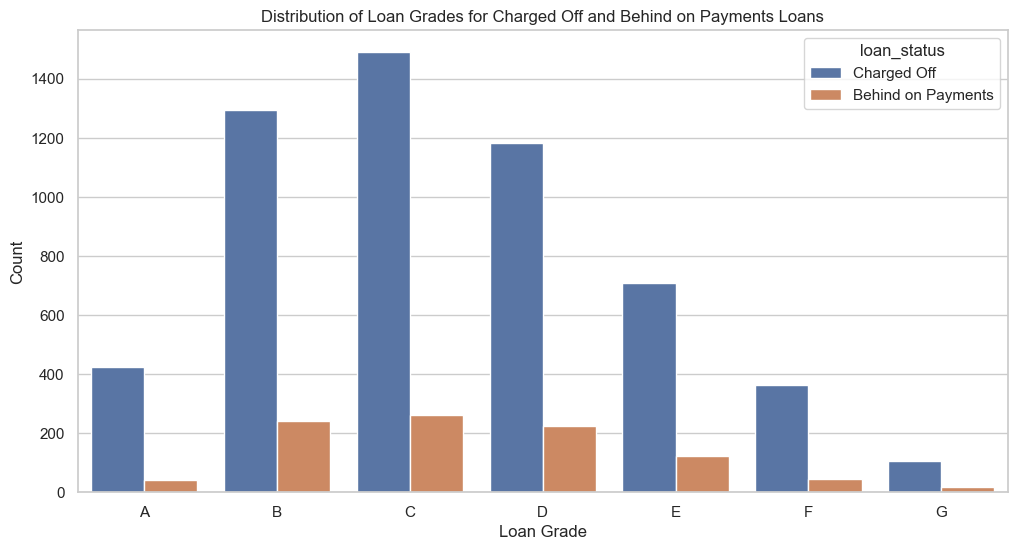

In [31]:
sns.set(style="whitegrid")

# Visualizing the distribution of loan grades
plt.figure(figsize=(12, 6))
sns.countplot(data=combined_subset, x='grade', hue='loan_status', order=sorted(combined_subset['grade'].unique()))
plt.title('Distribution of Loan Grades for Charged Off and Behind on Payments Loans')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.show()


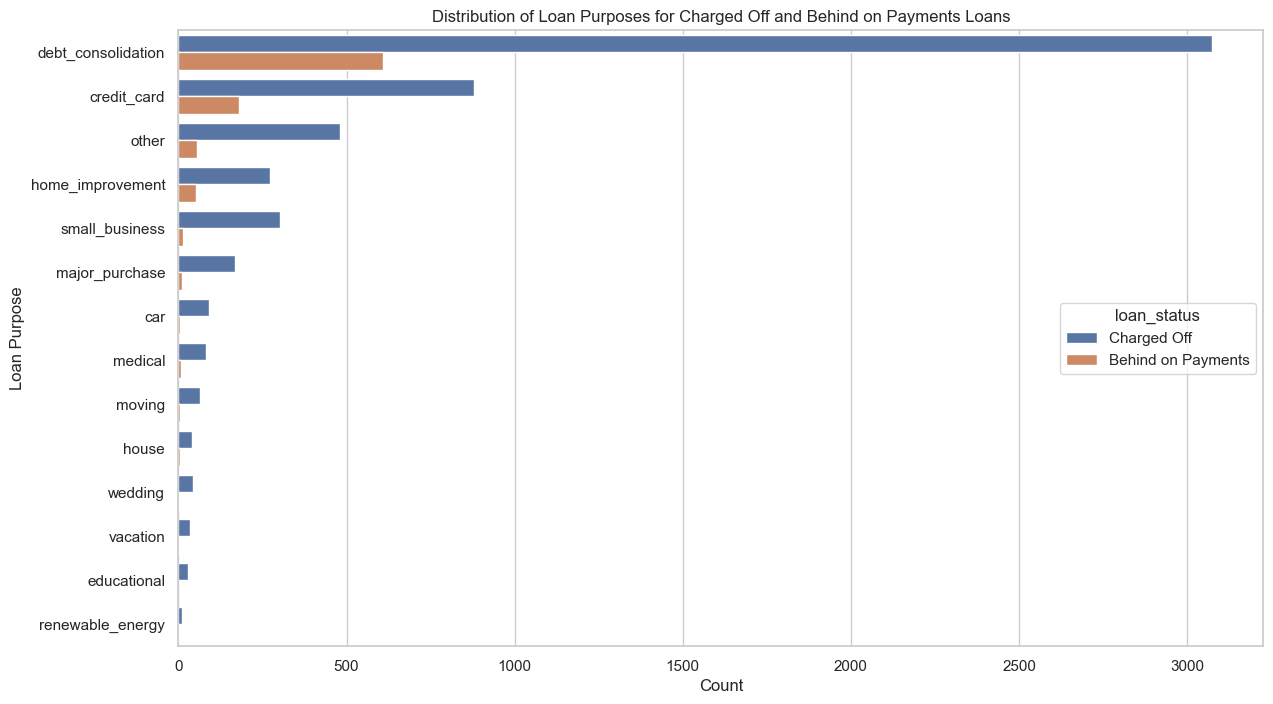

In [32]:
# Visualizing the reasons for the loans (purposes)
plt.figure(figsize=(14, 8))
sns.countplot(data=combined_subset, y='purpose', hue='loan_status', order=combined_subset['purpose'].value_counts().index)
plt.title('Distribution of Loan Purposes for Charged Off and Behind on Payments Loans')
plt.xlabel('Count')
plt.ylabel('Loan Purpose')
plt.show()


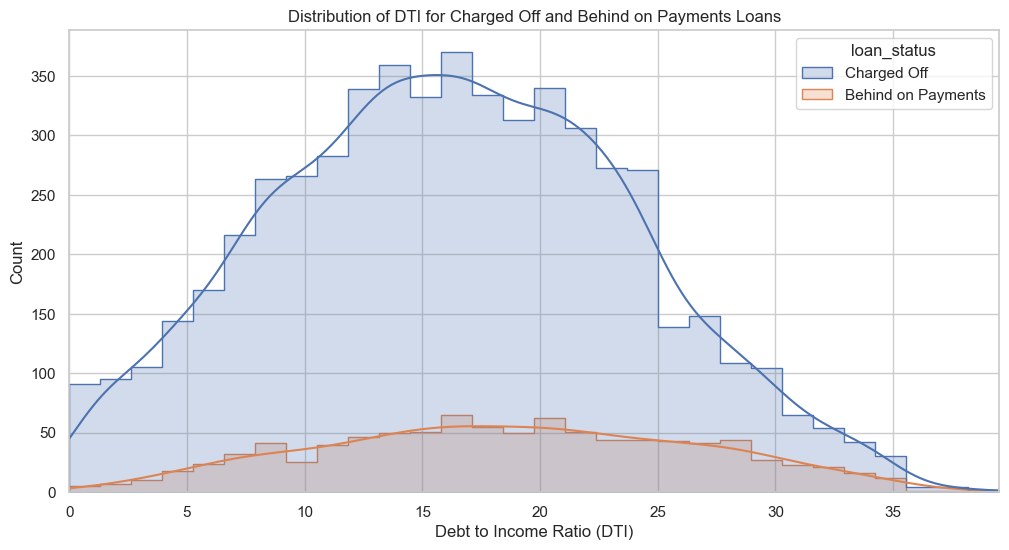

In [33]:
# Visualizing the distribution of DTI (Debt to Income Ratio)
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_subset, x='dti', hue='loan_status', element='step', bins=30, kde=True)
plt.title('Distribution of DTI for Charged Off and Behind on Payments Loans')
plt.xlabel('Debt to Income Ratio (DTI)')
plt.ylabel('Count')
plt.xlim(0, combined_subset['dti'].max())  # Limiting the x-axis for better readability
plt.show()


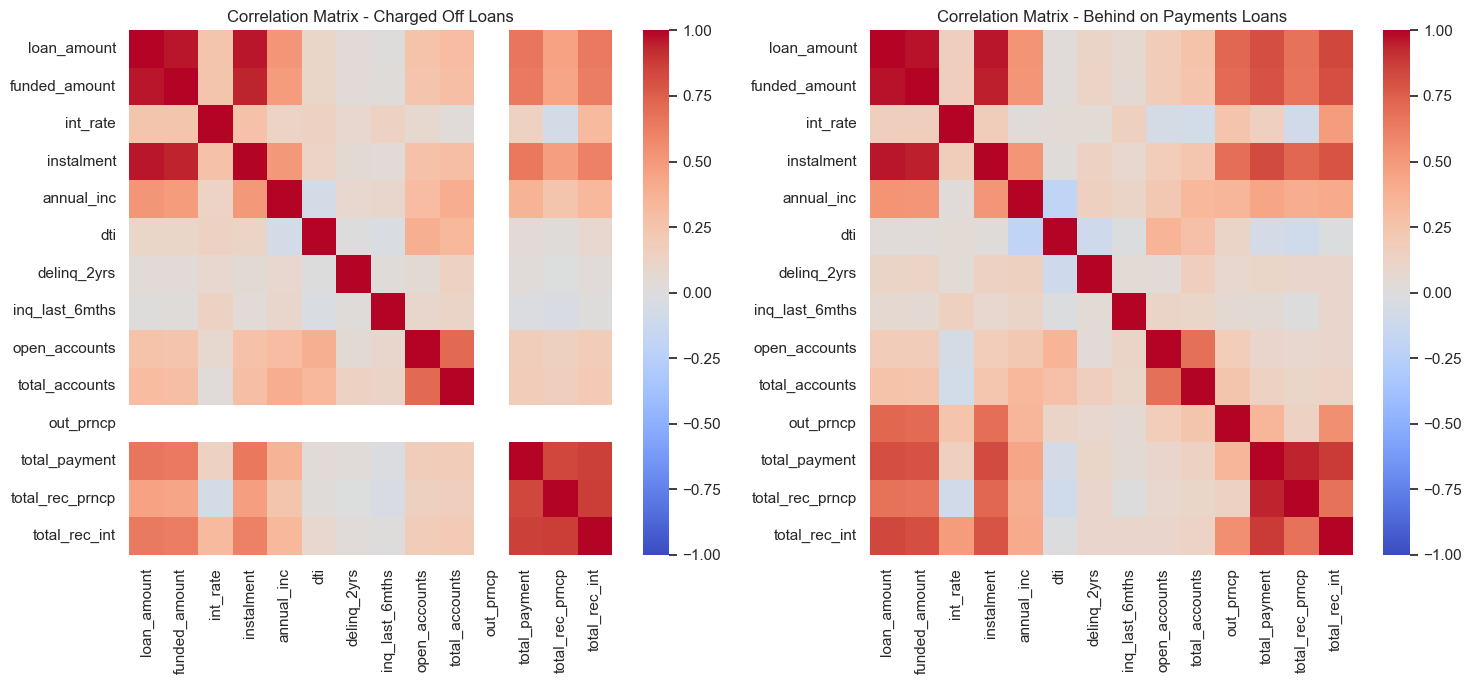

In [34]:
# Selecting key columns for correlation analysis
key_columns = ['loan_amount', 'funded_amount', 'int_rate', 'instalment', 'annual_inc',
               'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_accounts', 'total_accounts',
               'out_prncp', 'total_payment', 'total_rec_prncp', 'total_rec_int']

# Creating subsets for correlation analysis
charged_off_corr_subset = charged_off_loans[key_columns]
behind_on_payments_corr_subset = behind_on_payments_loans[key_columns]

# Calculating correlation matrices
corr_charged_off = charged_off_corr_subset.corr()
corr_behind_on_payments = behind_on_payments_corr_subset.corr()

# Plotting the correlation matrices
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.heatmap(corr_charged_off, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Charged Off Loans')

plt.subplot(1, 2, 2)
sns.heatmap(corr_behind_on_payments, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Behind on Payments Loans')

plt.tight_layout()
plt.show()
